In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.layers import Dropout
import tensorflow as tf
from keras.models import load_model
import pandas_ta as ta




In [2]:
df = pd.read_csv('BTC-USDday.csv')
df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])
df['RSI'] = ta.rsi(df['Close'], length=100)
df['EMAF'] = ta.ema(df['Close'], length=20)
# df['EMAM'] = ta.ema(df['Close'], length=50)
# df['EMAS'] = ta.ema(df['Close'], length=100)
df = df.drop(columns=['Volume'])
df = df.drop(columns=['Date'])
df_set = df.iloc[100: , 0:10]
print(type(df_set))

print(df_set.shape)
sc = MinMaxScaler(feature_range=(0,1))
df_scaled = sc.fit_transform(df_set)

open = np.array(df_scaled[:, 0])
high = np.array(df_scaled[:, 1])
low = np.array(df_scaled[:, 2])
close = np.array(df_scaled[:, 3])
adj_close = np.array(df_scaled[:, 4])
date = np.array(df.index) #行数
atr = np.array(df_scaled[:, 5])
rsi = np.array(df_scaled[:, 6])
emaf = np.array(df_scaled[:, 7])
# emam = np.array(df_scaled[:, 8])
# emas = np.array(df_scaled[:, 9])

<class 'pandas.core.frame.DataFrame'>
(3310, 8)


In [3]:
X = []
y = []
for i in range(len(open)-31):
    X_i = np.vstack((open[i:i+30], high[i:i+30], low[i:i+30], close[i:i+30], adj_close[i:i+30],atr[i:i+30], rsi[i:i+30], emaf[i:i+30])).T
    Y_i = adj_close[i+30]
    X.append(X_i)
    y.append(Y_i)
X = np.array(X)
y = np.array(y)

# X[i] = 过去9天里的ohlc和adj_c
# y[i] = 第10天的adj_c
X.shape

(3279, 30, 8)

In [4]:

train_ratio = 0.6
cv_ratio = 0.2

num_samples = 3269
num_train_samples = int(num_samples * train_ratio)
num_cv_samples = int(num_samples * cv_ratio)
indices = np.random.permutation(num_samples)

X_train = X[indices[:num_train_samples]]
y_train = y[indices[:num_train_samples]]
X_cv = X[indices[num_train_samples:num_train_samples + num_cv_samples]]
y_cv = y[indices[num_train_samples:num_train_samples + num_cv_samples]]
X_test = X[indices[num_train_samples + num_cv_samples:]]
y_test = y[indices[num_train_samples + num_cv_samples:]]

X_test



array([[[0.11852015, 0.11935344, 0.11758344, ..., 0.05290704,
         0.33117653, 0.1151646 ],
        [0.11733807, 0.11476825, 0.11585606, ..., 0.0525045 ,
         0.31860937, 0.11576552],
        [0.11431032, 0.1159969 , 0.11410968, ..., 0.05498649,
         0.33689982, 0.11674394],
        ...,
        [0.13530594, 0.13298067, 0.13504345, ..., 0.05274428,
         0.39394335, 0.13811784],
        [0.13368175, 0.1383765 , 0.1358121 , ..., 0.05660665,
         0.42050149, 0.13915543],
        [0.14012953, 0.14017474, 0.14149268, ..., 0.05658146,
         0.42750347, 0.14027019]],

       [[0.41532797, 0.41692159, 0.40157475, ..., 0.24865252,
         0.46756004, 0.39499546],
        [0.40261122, 0.41584993, 0.40796901, ..., 0.25293535,
         0.49023955, 0.39987782],
        [0.41778282, 0.41087156, 0.40579265, ..., 0.25409333,
         0.46681715, 0.40302391],
        ...,
        [0.43448066, 0.44122924, 0.43774502, ..., 0.17839216,
         0.5109737 , 0.45845484],
        [0.4

In [5]:
model = Sequential()
model.add(LSTM(250, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50, kernel_regularizer=l2(0.001)))
model.add(Dense(25,kernel_regularizer=l2(0.001)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=80, batch_size=64)
model.save('daily30-0_model.h5')


Epoch 1/80
31/31 [==============================] - 3s 71ms/step - loss: 0.1007 - val_loss: 0.0872
Epoch 2/80
31/31 [==============================] - 2s 68ms/step - loss: 0.0800 - val_loss: 0.0721
Epoch 3/80
31/31 [==============================] - 2s 64ms/step - loss: 0.0657 - val_loss: 0.0589
Epoch 4/80
31/31 [==============================] - 2s 66ms/step - loss: 0.0535 - val_loss: 0.0478
Epoch 5/80
31/31 [==============================] - 2s 66ms/step - loss: 0.0433 - val_loss: 0.0386
Epoch 6/80
31/31 [==============================] - 2s 66ms/step - loss: 0.0351 - val_loss: 0.0314
Epoch 7/80
31/31 [==============================] - 2s 66ms/step - loss: 0.0285 - val_loss: 0.0254
Epoch 8/80
31/31 [==============================] - 2s 65ms/step - loss: 0.0231 - val_loss: 0.0207
Epoch 9/80
31/31 [==============================] - 2s 67ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 10/80
31/31 [==============================] - 2s 70ms/step - loss: 0.0157 - val_loss: 0.0140
Epoch 11/

/Users/guanyulu/anaconda3/envs/btcp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:

test_predict = model.predict(X_test)
original_shape_array = np.zeros((len(test_predict), 8))
print(original_shape_array.shape)
original_shape_array[:, 0] = test_predict.ravel()
print(original_shape_array[:,0].shape)


original_shape_y = np.zeros((len(y_test), 8))
original_shape_y[:,0] = y_test

mse = np.mean((original_shape_array[:,0] - original_shape_array[:,0]) ** 2)
print(mse)


y_test_original = sc.inverse_transform(original_shape_y)[:,0]

yhat = sc.inverse_transform(original_shape_array)[:,0]
print(yhat.shape)


mse2 = np.mean((y_test_original - yhat) ** 2)
print(mse2)





21/21 [==============================] - 1s 12ms/step
(655, 8)
(655,)
0.0
(655,)
1394783.137505701


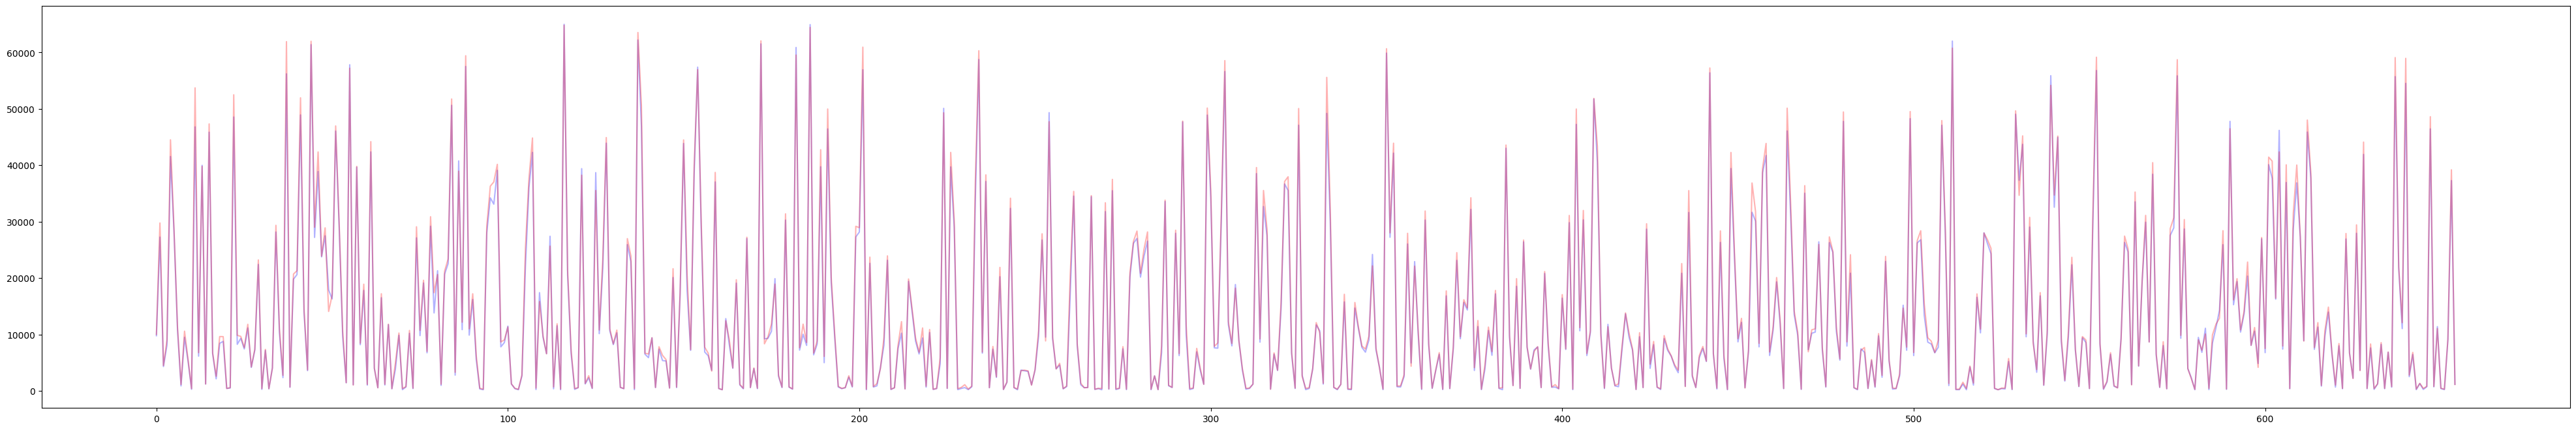

In [7]:
plt.figure(figsize=(50,8))
plt.plot(y_test_original,color = 'blue', alpha=0.3, label='predict')
plt.plot(yhat, color = "red",alpha=0.3, label='actuall')

In [8]:
latest_data = df[-31:-1]  # 获取最后31行数据

latest_data_scaled = sc.fit_transform(latest_data)

# 构建输入数据，这里需要注意维度匹配
X_latest = np.array([latest_data_scaled])
X_latest = np.reshape(X_latest, (1, 30, 8))  # 1个样本，9个时间步，每步5个特征

# 使用模型进行预测
predicted_price = model.predict(X_latest)
print(predicted_price)
# 反归一化预测结果以获取实际的价格
predicted_price_original = sc.inverse_transform(np.hstack((predicted_price, np.zeros((predicted_price.shape[0], 7)))))[:, 0]

# 输出预测的闭市价
print(f"Predicted closing price for the next day: {predicted_price_original[0]}")


1/1 [==============================] - 0s 13ms/step
[[0.20358652]]
Predicted closing price for the next day: 42496.31657341495


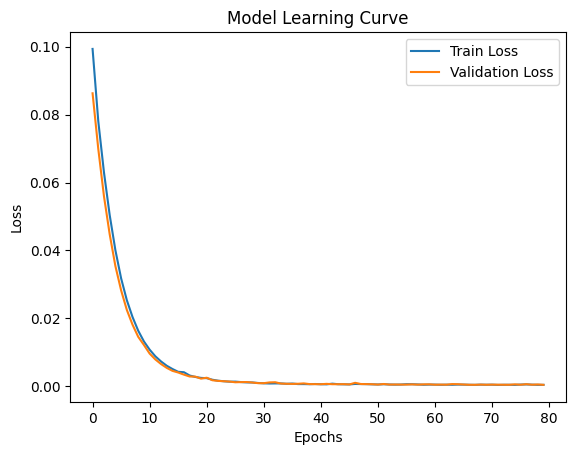

In [51]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
